# Basic Concepts in Search Algorithms (Optional)

This notebook serves as suporting material for topics covered in **Lecture 3 - Uninformed Search** and **Lecture 4 - Informed Search** from the lecture *Grundlagen der Künstlichen Intelligenz(IN2062)* at the Technical University of Munich. This notebook uses implementations from [search.py](https://github.com/aimacode/aima-python/blob/master/search.py) module. Let's start by importing everything from the search module.

*Note: this notebook is optional, if you just want to see the visualization of the search algorithms we mentioned in the lecture, it's ok to skip this notebook and start directly with notebook 1: simple tree search.*

## How to use this notebook
Clone the aima-python repository to your local machine, and add this notebook directly to the root directory of aima-python in order to make the following imports work.

There is also a bigger notebook, *search.ipynb*, in the same root directory, which contains more examples from the book *Artificial Intelligence: A Modern Approach*. 

### Overview
In this notebook, we will introduce some important concepts in search algorithms, namely:
* Problem
* Node
* Graph

They serve as a foundation of the search algorithms we will write in the following notebooks. You will also benefit from the way of thinking: how to decompose a problem, how to model it and how to solve it by searching.  

So, despite of being a little tedious to read this notebook, we highly suggest you first get an idea of those concepts before moving on to other notebooks we provide. Then, if anything is not clear, you can always come back and review some of the ideas here.

In [1]:
from search import *
from notebook import psource, heatmap, gaussian_kernel, show_map, final_path_colors, display_visual, plot_NQueens

# Needed to hide warnings in the matplotlib sections
import warnings
warnings.filterwarnings("ignore")

## PROBLEM

Let's see how we define a Problem. Run the next cell to see how abstract class `Problem` is defined in the search module.

In [2]:
psource(Problem)

The `Problem` class has six methods.

* `__init__(self, initial, goal)` : This is what is called a `constructor`. It is the first method called when you create an instance of the class as `Problem(initial, goal)`. The variable `initial` specifies the initial state $s_0$ of the search problem. It represents the beginning state. From here, our agent begins its task of exploration to find the goal state(s) which is given in the `goal` parameter.


* `actions(self, state)` : This method returns all the possible actions agent can execute in the given state `state`.


* `result(self, state, action)` : This returns the resulting state if action `action` is taken in the state `state`. This `Problem` class only deals with deterministic outcomes. So we know for sure what every action in a state would result to.


* `goal_test(self, state)` : Return a boolean for a given state - `True` if it is a goal state, else `False`.


* `path_cost(self, c, state1, action, state2)` : Return the cost of the path that arrives at `state2` as a result of taking `action` from `state1`, assuming total cost of `c` to get up to `state1`.


* `value(self, state)` : This acts as a bit of extra information in problems where we try to optimise a value when we cannot do a goal test.

## NODE

Let's see how we define a Node. Run the next cell to see how abstract class `Node` is defined in the search module.

In [3]:
psource(Node)

The `Node` class has nine methods. The first is the `__init__` method.

* `__init__(self, state, parent, action, path_cost)` : This method creates a node. `parent` represents the node that this is a successor of and `action` is the action required to get from the parent node to this node. `path_cost` is the cost to reach current node from parent node.

The next 4 methods are specific `Node`-related functions.

* `expand(self, problem)` : This method lists all the neighbouring(reachable in one step) nodes of current node. 

* `child_node(self, problem, action)` : Given an `action`, this method returns the immediate neighbour that can be reached with that `action`.

* `solution(self)` : This returns the sequence of actions required to reach this node from the root node. 

* `path(self)` : This returns a list of all the nodes that lies in the path from the root to this node.

The remaining 4 methods override standards Python functionality for representing an object as a string, the less-than ($<$) operator, the equal-to ($=$) operator, and the `hash` function.

* `__repr__(self)` : This returns the state of this node.

* `__lt__(self, node)` : Given a `node`, this method returns `True` if the state of current node is less than the state of the `node`. Otherwise it returns `False`.

* `__eq__(self, other)` : This method returns `True` if the state of current node is equal to the other node. Else it returns `False`.

* `__hash__(self)` : This returns the hash of the state of current node.

In [4]:
psource(GraphProblem)

Have a look at our romania_map, which is an Undirected Graph containing a dict of nodes as keys and neighbours as values.

In [5]:
romania_map = UndirectedGraph(dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142)))

romania_map.locations = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))

It is pretty straightforward to understand this `romania_map`. The first node **Arad** has three neighbours named **Zerind**, **Sibiu**, **Timisoara**. Each of these nodes are 75, 140, 118 units apart from **Arad** respectively. And the same goes with other nodes.

And `romania_map.locations` contains the positions of each of the nodes. We will use the straight line distance (which is different from the one provided in `romania_map`) between two cities in algorithms like A\*-search and Recursive Best First Search.

**Define a problem:**
Now it's time to define our problem. We will define it by passing `initial`, `goal`, `graph` to `GraphProblem`. So, our problem is to find the goal state starting from the given initial state on the provided graph. 

Say we want to start exploring from **Arad** and try to find **Bucharest** in our romania_map. So, this is how we do it.

In [6]:
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)

### Romania Map Visualisation

Let's have a visualisation of Romania map [Figure 3.2] from the book and see how different searching algorithms perform / how frontier expands in each search algorithm for a simple problem named `romania_problem`.

Have a look at `romania_locations`. It is a dictionary defined in search module. We will use these location values to draw the romania graph using **networkx**.

In [7]:
romania_locations = romania_map.locations
print(romania_locations)

{'Arad': (91, 492), 'Bucharest': (400, 327), 'Craiova': (253, 288), 'Drobeta': (165, 299), 'Eforie': (562, 293), 'Fagaras': (305, 449), 'Giurgiu': (375, 270), 'Hirsova': (534, 350), 'Iasi': (473, 506), 'Lugoj': (165, 379), 'Mehadia': (168, 339), 'Neamt': (406, 537), 'Oradea': (131, 571), 'Pitesti': (320, 368), 'Rimnicu': (233, 410), 'Sibiu': (207, 457), 'Timisoara': (94, 410), 'Urziceni': (456, 350), 'Vaslui': (509, 444), 'Zerind': (108, 531)}


Let's get started by initializing an empty graph. We will add nodes, place the nodes in their location as shown in the book, add edges to the graph.

In [8]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in romania_map.locations.keys()}
node_positions = romania_map.locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in romania_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in romania_map.graph_dict.items() for k2, v2 in v.items()}

romania_graph_data = {  'graph_dict' : romania_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }

We have completed building our graph based on romania_map and its locations. It's time to display it here in the notebook. This function `show_map(node_colors)` helps us do that. We will be calling this function later on to display the map at each and every interval step while searching, using variety of algorithms from the book.

We can simply call the function with node_colors dictionary object to display it.

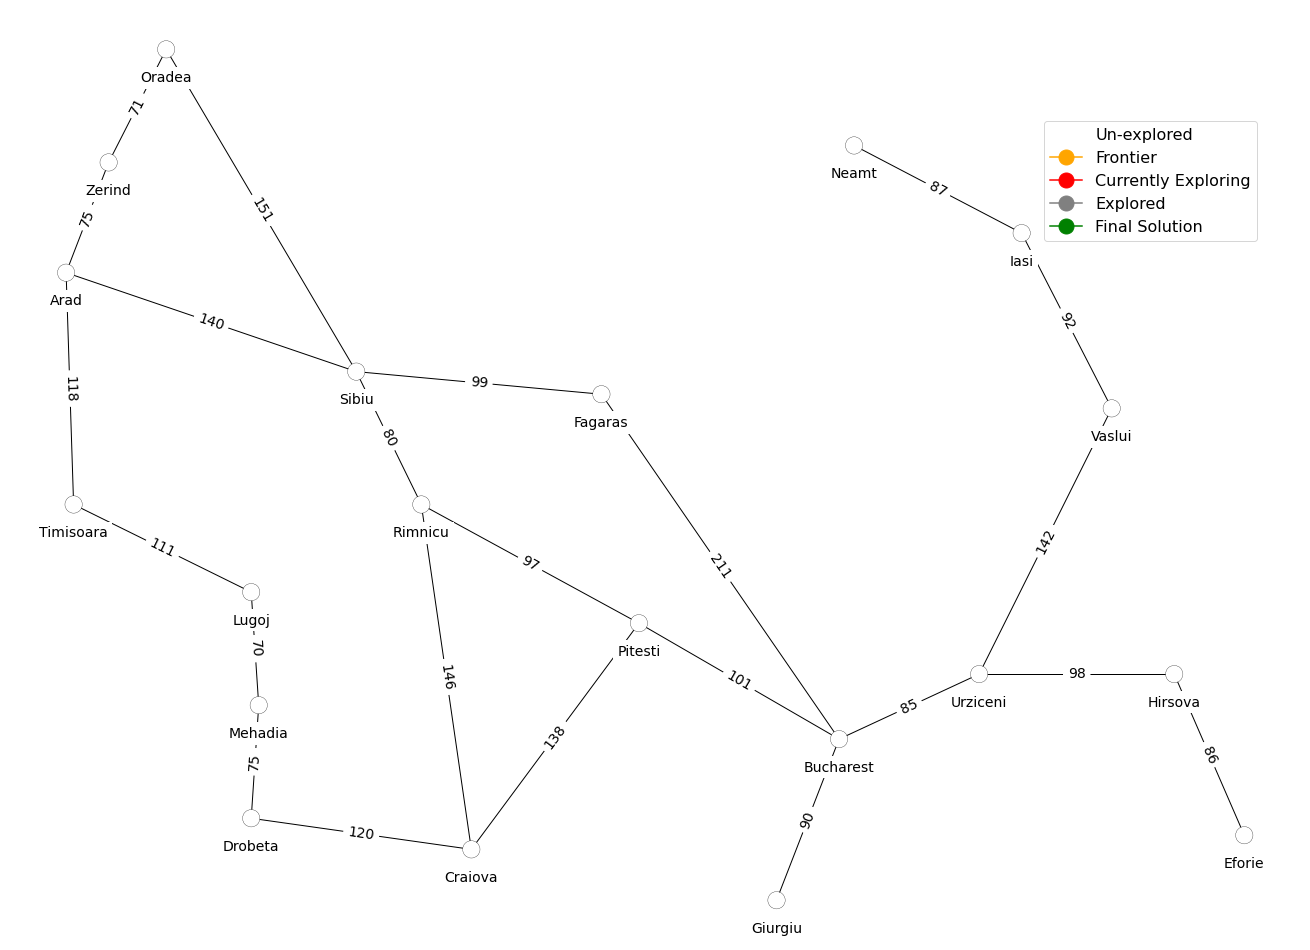

In [9]:
show_map(romania_graph_data)